1/1 [==============================] - 0s 464ms/step


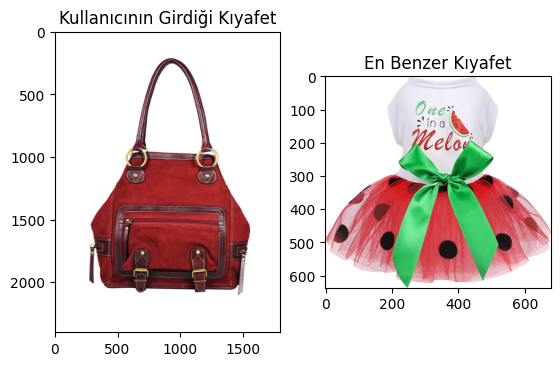

In [43]:
import cv2
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
import numpy as np
import os
import matplotlib.pyplot as plt

# Önceden eğitilmiş VGG16 modelini yükle
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def get_vgg16_features(img_array):
    features = model.predict(img_array)
    return features.flatten()

def calculate_color_histogram(image_path):
    img = cv2.imread(image_path)

    # Renk histogramını hesapla
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def calculate_histogram_similarity(hist1, hist2):
    # Histogram benzerliğini hesapla
    similarity = cv2.compareHist(hist1, hist2, cv2.HISTCMP_INTERSECT)
    return similarity

def find_most_similar_clothing(input_clothing_path, clothing_folder):
    input_clothing_img = preprocess_image(input_clothing_path)
    input_clothing_vgg16_features = get_vgg16_features(input_clothing_img)
    input_clothing_hist = calculate_color_histogram(input_clothing_path)

    most_similar_clothing = None
    max_similarity = -1  # Minimum similarity to start with

    for clothing_img_path in os.listdir(clothing_folder):
        if clothing_img_path.endswith('.jpg'):
            clothing_img_path = os.path.join(clothing_folder, clothing_img_path)
            clothing_img = preprocess_image(clothing_img_path)
            clothing_vgg16_features = get_vgg16_features(clothing_img)
            clothing_hist = calculate_color_histogram(clothing_img_path)

            vgg16_similarity = np.dot(input_clothing_vgg16_features, clothing_vgg16_features) / (
                    np.linalg.norm(input_clothing_vgg16_features) * np.linalg.norm(clothing_vgg16_features))
            hist_similarity = calculate_histogram_similarity(input_clothing_hist, clothing_hist)

            overall_similarity = (vgg16_similarity + hist_similarity) / 2

            if overall_similarity > max_similarity:
                max_similarity = overall_similarity
                most_similar_clothing = clothing_img_path

    return most_similar_clothing, max_similarity

# Verilen bir örnek kıyafet ve benzerlik ölçmek istediğiniz kıyafet dizini
input_clothing_path = '/content/10732.jpg'
clothing_folder = '/content/ss'

# En benzer kıyafeti bul
most_similar_clothing, similarity_score = find_most_similar_clothing(input_clothing_path, clothing_folder)

# Kullanıcının girdiği kıyafeti göster
input_clothing_img = cv2.imread(input_clothing_path)
input_clothing_rgb = cv2.cvtColor(input_clothing_img, cv2.COLOR_BGR2RGB)

# En benzer kıyafeti göster
most_similar_img = cv2.imread(most_similar_clothing)
most_similar_rgb = cv2.cvtColor(most_similar_img, cv2.COLOR_BGR2RGB)

# Matplotlib ile görselleştirme
plt.subplot(1, 2, 1)
plt.imshow(input_clothing_rgb)
plt.title("Kullanıcının Girdiği Kıyafet")

plt.subplot(1, 2, 2)
plt.imshow(most_similar_rgb)
plt.title("En Benzer Kıyafet")

plt.show()
